In [ ]:
# @title
from IPython.display import HTML

# HTML y CSS para el título y la imagen en Google Colab
html_code = """
<style>
  #container {
    display: flex;
    justify-content: space-between;
    align-items: center;
    padding: 10px;
  }

  #title {
    font-size: 50px;
    font-weight: bold;
    color: black;
  }

  #logo {
    width: 174px;
    height: 101.5px;
  }
</style>

<div id="container">
  <div id="title">SunScan</div>
  <img id="logo" src="https://www.valoraanalitik.com/wp-content/uploads/2023/10/bid-696x406.jpg" alt="Logo">
</div>
"""

# Mostrar el código HTML en Colab
display(HTML(html_code))


In [ ]:
#@title 1. Configurar ambiente
%%time

!git clone https://github.com/sesaga478/SolarEnergy_From_Satellite
%cd '/content/SolarEnergy_From_Satellite'
!pip install --user -r requirements.txt

Reiniciar entorno de ejecución

In [1]:
#@title 2. Cargar dependencias

import os,glob, sys

fol_sys='/content/SolarEnergy_From_Satellite/scripts'
if fol_sys not in sys.path:
    sys.path.append(fol_sys)

from samgeo.text_sam import LangSAM
import leafmap
import shp_down_bb as sdb
import city_from_coord as cfc
import ultimo_archivo as ua
import sunlight_hours as sunh
import solar_energy_shp as ses
import datetime

sam = LangSAM()

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:16<00:00, 159MB/s]


In [8]:
#@title 3. Escoger un área sobre el mapa para realizar el análisis

m_bb=leafmap.Map()
m_bb.add_basemap("Google Satellite")
m_bb

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [9]:
#@title 4. Descargar la imagen


bb=m_bb.user_roi_bounds()
north, south, east, west = bb[3], bb[1], bb[2], bb[0]
lat,lon=((north+south)/2),((east+west)/2)#Centroid

#Get name of the city with coordinates
city=cfc.city_from_coord(latitude=lat, longitude=lon)
city_name=str(city).replace("'",'').replace('(','').replace(')','').replace(', ','_').replace(' ','').replace('/','')

#Crear la carpeta donde estarán las imágenes y predicciones
if not os.path.exists(city_name):
        os.makedirs(city_name)

z=20
#image = '/content/'+city_name+'_z{}.tif'.format(str(z))
image=os.path.join(city_name,city_name+'_{}z.tif'.format(str(z)))
leafmap.tms_to_geotiff(image, bb, zoom=z,
                       source='Satellite')

Downloaded image 1/25
Downloaded image 2/25
Downloaded image 3/25
Downloaded image 4/25
Downloaded image 5/25
Downloaded image 6/25
Downloaded image 7/25
Downloaded image 8/25
Downloaded image 9/25
Downloaded image 10/25
Downloaded image 11/25
Downloaded image 12/25
Downloaded image 13/25
Downloaded image 14/25
Downloaded image 15/25
Downloaded image 16/25
Downloaded image 17/25
Downloaded image 18/25
Downloaded image 19/25
Downloaded image 20/25
Downloaded image 21/25
Downloaded image 22/25
Downloaded image 23/25
Downloaded image 24/25
Downloaded image 25/25
Saving GeoTIFF. Please wait...
Image saved to NA_Santander/NA_Santander_20z.tif


In [10]:
#@title 5. Visualizar las imágenes

#path='/content'
palabra_clave='z.tif'
img_in=ua.ultimo_archivo('/content', '.tif')

m0=leafmap.Map()
m0.add_raster(img_in)
m0

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

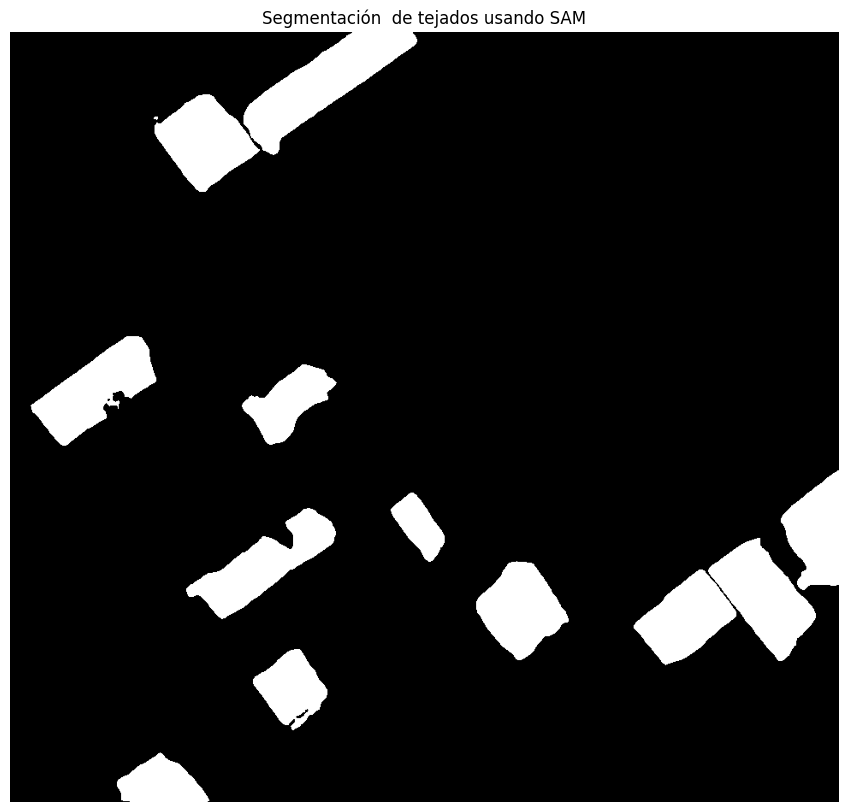

In [11]:
#@title 6. Usar SAM para detectar los tejados

sam.predict(img_in, "house", box_threshold=0.24, text_threshold=0.24)

#Crear el raster
#tif_out=img_in.replace('.tif','_sam_{}.tif'.format(text_prompt))
tif_out=img_in.replace('.tif','_sam_rooftop.tif')
sam.show_anns(  cmap='Greys_r',  add_boxes=False,  alpha=1,
  #title='Segmentation of {}'.format(text_prompt),
  title='Segmentación  de tejados usando SAM', blend=False,  output=tif_out)

#Crear el shp
shp_out=tif_out.replace('.tif','.shp')
sam.raster_to_vector(tif_out,shp_out)

m1=leafmap.Map()
m1.add_raster(img_in)
m1.add_vector(shp_out)
m1

In [44]:
#@title 7. Energía solar: Esoger parámetros

import ipywidgets as widgets
from IPython.display import display

print('Por favor, use el deslizador para escoger: \n  - Tamaño del panel solar en m2 (Default. 4m2) \n  - Potencia del panel solar en watts  (Default. 400 watts)\n  - Disponibilidad del tejado para poner paneles en % (Default. 50%) \n \n')

metros_cuadrados_widget = widgets.IntSlider(
    value=4,  min=2,  max=10, step=1, description='Panel m2')

potencia_widget = widgets.IntSlider(
    value=400, min=200, max=1000, step=100, description='Panel watts')

disponib_widget = widgets.IntSlider(
    value=50, min=0, max=100, step=10, description='Panel disponib')

horizontal_box = widgets.HBox([metros_cuadrados_widget, potencia_widget,disponib_widget])

display(horizontal_box)


Por favor, use el deslizador para escoger: 
  - Tamaño del panel solar en m2 (Default. 4m2) 
  - Potencia del panel solar en watts  (Default. 400 watts)
  - Disponibilidad del tejado para poner paneles en % (Default. 50%) 
 



In [47]:
#@title 8. Energía solar: Estimación de generación anual

#Parámetros
panel_size=metros_cuadrados_widget.value
area_disp=disponib_widget.value/100
factor_dim=0.8
panel_pot=potencia_widget.value/1000

palabra_clave='.shp'
shp_in=ua.ultimo_archivo(city_name, palabra_clave)
shp_out=shp_in.replace('.shp','_ener.shp')
excel_out=shp_in.replace('.shp','.xlsx')

start = datetime.datetime(2024, 1, 1, 0, 0, 0)
end = datetime.datetime(2024, 12, 31, 0, 0, 0)

delta = end - start

ses.solar_energy_shp(shp_in,shp_out,start,end,panel_size,area_disp,factor_dim,panel_pot,excel_out)

msol=leafmap.Map()
msol.add_raster(img_in)
msol.add_vector(shp_out)
msol

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [13]:
#@title 9. Exportar el resultado (zip con todos los resultados)
import zipfile
from google.colab import files

zip_results = city_name+'.zip'

# Create a ZipFile object in write mode
with zipfile.ZipFile(zip_results, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the folder and add each file to the zip archive
    for foldername, subfolders, filenames in os.walk(city_name):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, city_name)  # Use relative path as the archive name
            zipf.write(file_path, arcname)


files.download(zip_results)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>